In [137]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import patsy as pt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
import math
import statistics
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

plt.rcParams.update(plt.rcParamsDefault)

In [234]:
def pure_data(filename):

    data = pd.read_csv(filename, sep=',')
    
    added = []
    for index, row in data.iterrows():
        code = row['participant.code']
        subsession = row['subsession.round_number']
        group = row['group.id_in_subsession']
        partner = data[(data['subsession.round_number'] == subsession) & (data['group.id_in_subsession'] == group) & (data['participant.code'] != code)]
        added.append(partner.iloc[0, 7])
        
    data['opponent.decision'] = added
    
    data = data.drop(data[data['subsession.round_number'] > 30].index)
    
    return data

In [235]:
df = pure_data('05.03.21.csv')

In [313]:
def intercount(df, period=None):
    
    if period == None:
        data = df
    else:
        data = df[df['subsession.round_number'] == period]
    
    actions = {}
    actions['AA'] = ['Isolation', 'Isolation', 0]
    actions['AB'] = ['Isolation', 'Suspicion', 0]
    actions['AC'] = ['Isolation', 'Interaction', 0]
    actions['BB'] = ['Suspicion', 'Suspicion', 0.25]
    actions['BC'] = ['Suspicion', 'Interaction', 0.5]
    actions['CC'] = ['Interaction', 'Interaction', 0.75]
    
    for key in actions:
        if actions[key][0] == actions[key][1]:
            num = data[(data['player.decision'] == actions[key][0]) & (data['opponent.decision'] == actions[key][1])].shape[0]
        else:
            num1 = data[(data['player.decision'] == actions[key][0]) & (data['opponent.decision'] == actions[key][1])].shape[0]
            num2 = data[(data['player.decision'] == actions[key][1]) & (data['opponent.decision'] == actions[key][0])].shape[0]
            num = num1 + num2
        actions[key].append(num)
        
    return actions

In [237]:
def avg_risk(dic):
    
    avg_risk = 0
    for key in dic:
        avg_risk += dic[key][2] * dic[key][3]
    
    return avg_risk

In [316]:
print(f'Средний риск взаимодействия в игре:\t{avg_risk(intercount(df))/840: .3f}')

Средний риск взаимодействия в игре:	 0.454


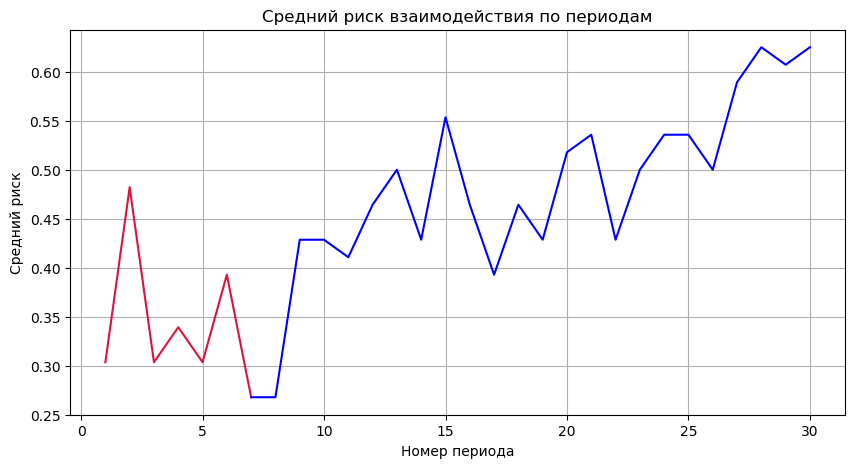

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
Средний риск,0.3,0.5,0.3,0.3,0.3,0.4,0.3,0.3,0.4,0.4,0.4,0.5,0.5,0.4,0.6,0.5,0.4,0.5,0.4,0.5,0.5,0.4,0.5,0.5,0.5,0.5,0.6,0.6,0.6,0.6


In [315]:
peravg_risk = [avg_risk(intercount(df, x))/28 for x in set(df['subsession.round_number'].iloc[:])]
    
massiv = np.array([[round(x, 1) for x in peravg_risk]])
table = pd.DataFrame(massiv, columns = list(set(df['subsession.round_number'].iloc[:])), index=['Средний риск'])
   
plt.figure(figsize = (10, 5))
x = np.arange(1, 31)
plt.plot(x[:7], np.array(peravg_risk)[:7], color = 'crimson', label = '1-7', linewidth = 1.5)
plt.plot(x[6:], np.array(peravg_risk)[6:], color = 'blue', label = '8+', linewidth = 1.5)
plt.title('Средний риск взаимодействия по периодам')
plt.xlabel('Номер периода')
plt.ylabel('Средний риск')
plt.grid()
plt.show()

pd.set_option('display.max_columns', None)
table

Наш случай особый, поэтому представляет интерес кроме целого графика две его части: до 7-го периода и после него.
На рисунке они раскрашены отдельно. Можно отчётливо видеть, что именно периоды 7-8 – минимум глобального тренда графика, объясняемого ставшим общеизвестным фактом, что заболеть отныне невозможно.
С другой стороны, информация такой силы должна была бы сделать скачок графика на 8-ом раунде максимальным, но та, в свою очередь, растёт постепенно, так и не достигая максимума в 0.75. Для анализа такого эффекта изучим сначала поведения конкретных игроков.

In [306]:
subdata = df[df['subsession.round_number'] < 31]

all_pairs = []

actions = {}
actions['AA'] = ['Isolation', 'Isolation', 0]
actions['AB'] = ['Isolation', 'Suspicion', 0]
actions['AC'] = ['Isolation', 'Interaction', 0]
actions['BB'] = ['Suspicion', 'Suspicion', 0.25]
actions['BC'] = ['Suspicion', 'Interaction', 0.5]
actions['CC'] = ['Interaction', 'Interaction', 0.75]

for index, row in subdata.iterrows():

    code = row['participant.code']
    subsession = row['subsession.round_number']
    group = row['group.id_in_subsession']
    partner = data[(data['subsession.round_number'] == subsession) & (data['group.id_in_subsession'] == group) & (data['participant.code'] != code)]
    
    pair = [row['participant.label'], row['player.status'], row['player.decision']]
    pair.append(partner.iloc[0, 2])
    pair.append(partner.iloc[0, 8])
    pair.append(partner.iloc[0, 7])
    
    action = [row['player.decision'], partner.iloc[0, 7]]
    for key in actions:
        if set(actions[key][0:2]) == set(action):
            pair.append(actions[key][2])
            break
    
    all_pairs.append(pair)
    
massiv = np.array(all_pairs)
col_titles = ['player#1', 'status#1', 'choice#1', 'player#2', 'status#2', 'choice#2', 'risk']
pairs = pd.DataFrame(massiv, columns = col_titles)

In [307]:
pd.set_option('display.max_rows', None)
pairs.head()

,player#1,status#1,choice#1,player#2,status#2,choice#2,risk
0,Меньшикова ОЛьга,Healthy,Isolation,Павлов Никита,Healthy,Interaction,0
1,Галиева Мадина,Healthy,Suspicion,Белоконь Леонид,Healthy,Interaction,0.5
2,Негримовский Дмитрий,Healthy,Interaction,Чабан Александр,Healthy,Isolation,0
3,Камалов Ринат,Healthy,Interaction,Борисов Никита,Healthy,Isolation,0
4,Морозов Анатолий,Healthy,Interaction,Колсов Семен,Healthy,Interaction,0.75


Получена таблица всех взаимодействий игроков. Выберем теперь те из них, в которых был шанс передачи болезни.

In [309]:
ill_pairs = pairs[(pairs['status#1'] == 'Ill') | (pairs['status#2'] == 'Ill')]
risky_pairs = ill_pairs[(ill_pairs['choice#1'] != 'Isolation') & (ill_pairs['choice#2'] != 'Isolation')]

risky_pairs

,player#1,status#1,choice#1,player#2,status#2,choice#2,risk
44,nan,Ill,Suspicion,Филиппова Валерия Михайловна,Healthy,Suspicion,0.25
51,Филиппова Валерия Михайловна,Healthy,Suspicion,nan,Ill,Suspicion,0.25
98,Тихонова Антонина,Healthy,Interaction,nan,Ill,Interaction,0.75
100,nan,Ill,Interaction,Тихонова Антонина,Healthy,Interaction,0.75
114,Негримовский Дмитрий,Healthy,Suspicion,nan,Ill,Interaction,0.5
128,nan,Ill,Interaction,Негримовский Дмитрий,Healthy,Suspicion,0.5
150,Липкин Константин,Healthy,Interaction,nan,Ill,Interaction,0.75
156,nan,Ill,Interaction,Липкин Константин,Healthy,Interaction,0.75


Получили четыре пары, которые могли с ненулевой вероятностью размножить болезнь, но все взаимодействия закончились удачно.
Вероятность такого события: $0,75*0,25*0,5*0,25 = 0,023,$ то есть всего лишь $2,3$%.

(≈7% – вероятность того, что все 4 пары, наоборот, заболели бы)

In [218]:
def get_letter(action):
    
    if action == 'Isolation':
        return 'A'
    elif action == 'Suspicion':
        return 'B'
    else:
        return 'C'

In [297]:
all_players = []

for i in np.arange(1, 29):
    
    subdata = df[df['participant.id_in_session'] == i]
    player = [subdata.iloc[0, 2]] + [get_letter(x) for x in subdata.iloc[:, 7]]
    player.append(player.count('A'))
    player.append(player.count('B'))
    player.append(player.count('C'))
    player.append(subdata.iloc[0, 3])
    
    all_players.append(player)

col_titles = ['player'] + list(np.arange(1, 31)) + ['#A', '#B', '#C', 'payoff']
players = pd.DataFrame(all_players, columns = col_titles)

Ниже представлена таблица, в которой собраны все действия за 30 периодов для каждого игрока, подсчитаны количества раз, которые каждый игрок выбирал то или иное действие.

In [301]:
players.sort_values('#C', ascending=False)

,player,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,#A,#B,#C,payoff
4,Морозов Анатолий,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,0,0,30,137
21,Губаренко Михаил,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,0,0,30,130
9,Кихтенко Андрей,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,0,0,30,132
20,Колсов Семен,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,0,0,30,133
18,Борисов Никита,A,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,1,0,29,136
10,Липкин Константин,C,C,C,C,C,C,C,C,C,B,C,C,C,C,C,B,C,C,C,C,C,C,C,C,C,C,C,C,C,C,0,2,28,131
6,Аминов Тимур,C,C,B,B,B,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,0,3,27,125
11,Молчанова Вероника,C,C,B,B,B,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,0,3,27,127
2,Негримовский Дмитрий,C,C,C,B,B,C,B,B,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,0,4,26,131
8,Павлов Никита,C,C,B,C,B,C,B,C,C,C,B,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,0,4,26,124


Оставим для наглядности лишь имена игроков и величины #A, #B, #C. Отсортируем для начала по #C.

Выбирая, по какой из величин #A, #B или #C разделить игроков на группы, сразу хочется отвергнуть #A - неинформативная величина, ярко выраженная лишь у нескольких игроков. Если отсортировать игроков сначала по #C, а после по #B, можно видеть, что порядки практически точно обратные, но в то же время #C выраженная практически у всех игроков величина.
Я решил отнести к первой группе игроков, которые в 75% случаев или больше выбирали Взаимодействие:

    Морозов Анатолий
    Губаренко Михаил
    Кихтенко Андрей
    Колсов Семён
    Борисов Никита
    Липкин Константин
    Аминов Тимур
    Молчанова Вероника
    Негримовский Дмитрий
    Павлов Никита
    Тихонова Антонина
    Колягина Вера
Ко второй группе отнёс тех игроков, которые в меньшей степени выбирали Взаимодействие, но, тем не менее, не редко – те люди, которые после 8-11 раундов в большинстве своём выбирали Взаимодействие:

    Камалов Ринат
    Белоконь Леонид
    Меньшикова ОЛьга
    Малин Алексей
    Сафина Эльмира
В третьей группе игроки, которые до самого конца не решились остановиться на выборе #C:

    Власов Александр
    Тимакова Марина
    Денисенко Екатерина
    Чабан Александр
    Галиева Мадина
    Шалимов Валентин
    Филиппова Валерия
    а также четыре бота

In [311]:
columns = ['player', '#A', '#B', '#C', 'payoff']
main = players[columns]

main.sort_values('#C', ascending=False)

,player,#A,#B,#C,payoff
4,Морозов Анатолий,0,0,30,137
21,Губаренко Михаил,0,0,30,130
9,Кихтенко Андрей,0,0,30,132
20,Колсов Семен,0,0,30,133
18,Борисов Никита,1,0,29,136
10,Липкин Константин,0,2,28,131
6,Аминов Тимур,0,3,27,125
11,Молчанова Вероника,0,3,27,127
2,Негримовский Дмитрий,0,4,26,131
8,Павлов Никита,0,4,26,124


Построим графики рисков взаимодействий каждой группы игроков по периодам.

In [349]:
group1_list = ['Морозов Анатолий','Губаренко Михаил','Кихтенко Андрей','Колсов Семён','Борисов Никита','Липкин Константин','Аминов Тимур','Молчанова Вероника','Негримовский Дмитрий','Павлов Никита','Тихонова Антонина','Колягина Вера']
group2_list = ['Камалов Ринат','Белоконь Леонид','Меньшикова ОЛьга','Малин Алексей','Сафина Эльмира']
group3_list = ['Власов Александр Анатольевич','Тимакова Марина','Денисенко Екатерина Васильевна','Чабан Александр','Галиева Мадина','Шалимов Валентин','Филиппова Валерия Михайловна', 'NaN']

In [350]:
def avg_risks(group_list=None):
    
    if group_list == None:
        peravg_risk = [avg_risk(intercount(df, x))/28 for x in set(df['subsession.round_number'].iloc[:])]
    else:
        group = df[df['participant.label'].isin(group_list)]
        peravg_risk = [avg_risk(intercount(group, x))/len(group_list) for x in set(group['subsession.round_number'].iloc[:])]
    
    
    return np.array(peravg_risk)

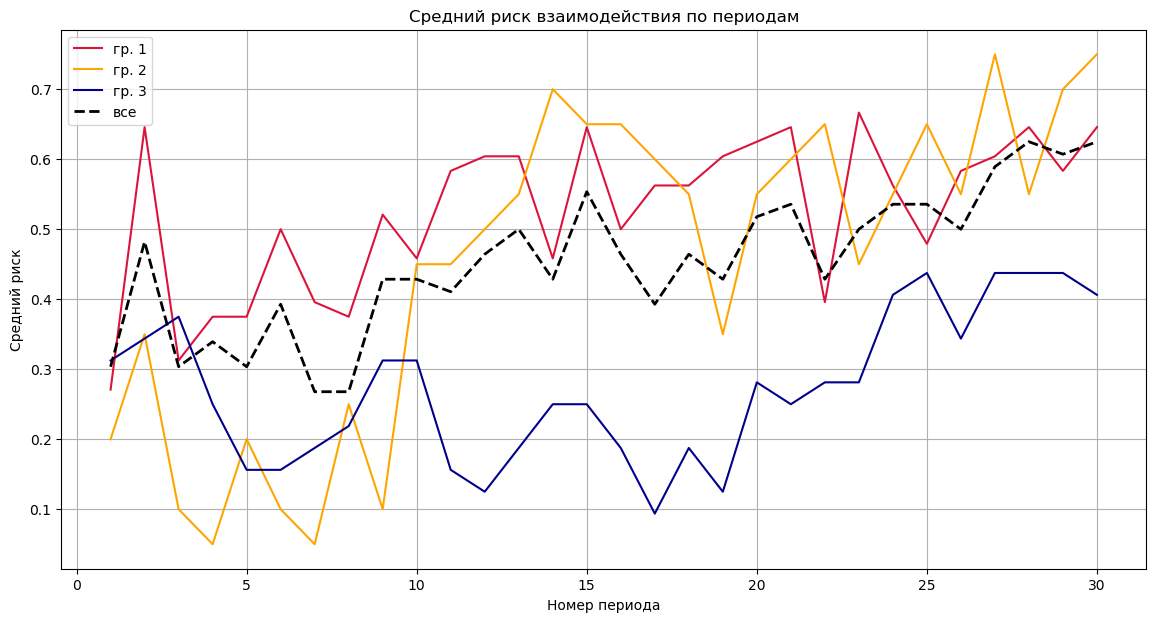

In [351]:
plt.figure(figsize = (14, 7))
x = np.arange(1, 31)
plt.plot(x, avg_risks(group1_list), color = 'crimson', label = 'гр. 1', linewidth = 1.5)
plt.plot(x, avg_risks(group2_list), color = 'orange', label = 'гр. 2', linewidth = 1.5)
plt.plot(x, avg_risks(group3_list), color = 'darkblue', label = 'гр. 3', linewidth = 1.5)
plt.plot(x, avg_risks(), color = 'black', linestyle = '--', label = 'все', linewidth = 2)

plt.title('Средний риск взаимодействия по периодам')
plt.xlabel('Номер периода')
plt.ylabel('Средний риск')
plt.grid()
plt.legend()
plt.show()

Действительно, можно наблюдать, что 1 и 2 группы отличаются тем, что первые 10 периодов делали слишком разные действия, но, начиная с 11го – имеют схожее поведение. 2 и 3 группы, наоборот – схожи первые 10 периодов, но потом 3 группа остаёт от 2й по степени взаимодействия (совершенно необоснованно с точки зрения правил игры и текущего положения в множестве игроков). Кстати, по сути, именно из-за 3й группы средний риск взаимодействия достиг максимальных 0.75 лишь дважды, хотя практически все, кроме 3й группы, после 10 (ну или уж точно после 17го периода) взаимодействовали по максимуму.

Момент, когда все три группы были на одном уровне риска мог слуйчиться на 2-3 периоде, но так и не совпал. Интересно, что в периоде 3 максимум по всем трём средним рискам минимален за всю игру – резкий спад. Во-первых, это похоже на мои собственные соображения во время игры – пару раундов провзаимодействовать, а после этого на всякий случай отсидеться. Во-вторых, это наверняка можно объяснить чем-то психологическим: хотя игроки (ну большинство точно) и знали, что в 3м раунде индикатор больных людей сменит значение с 0 на 1, но всё равно, это могло как-то повлиять на них.